In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Processing (Overall Sales)

## Putting given training data in a single df

In [128]:
holidays_df = pd.read_csv('holidays_events.csv')
oil_df = pd.read_csv('oil.csv')
stores_df = pd.read_csv('stores.csv')
train_df = pd.read_csv('train.csv')
transaction_df = pd.read_csv('transactions.csv')

In [129]:
sales_df = train_df.groupby('date').sum().drop(columns=['id', 'store_nbr'])

In [130]:
idx = pd.date_range('01-01-2013', '08-15-2017')

In [131]:
sales_df.index.name = None
sales_df.index = pd.DatetimeIndex(sales_df.index)
sales_df = sales_df.reindex(idx)

oil_df.index = oil_df['date']
oil_df = oil_df.drop(columns='date')
oil_df.index.name = None
oil_df.index = pd.DatetimeIndex(oil_df.index)
oil_df = oil_df.reindex(idx)

In [132]:
full_df = sales_df.copy()
full_df['oil'] = oil_df['dcoilwtico']

In [137]:
full_df = full_df.fillna(method='bfill') #filling empty spaces with the next day's

In [140]:
from sklearn.preprocessing import StandardScaler

In [141]:
sclr = StandardScaler()

In [142]:
sclr.fit(full_df.values)

StandardScaler()

In [144]:
full_scld = pd.DataFrame(data=sclr.transform(full_df.values), index=idx, columns=full_df.columns)

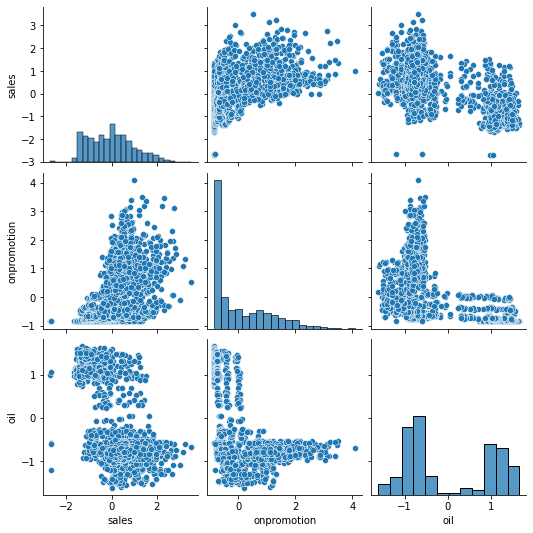

In [146]:
sns.pairplot(full_scld)

## Engineering some new features

### Moving averages (week + month)

In [169]:
full_scld['weekly avg sales'] = full_scld['sales'].rolling(window='7D', min_periods=1).mean()
full_scld['monthly avg sales'] = full_scld['sales'].rolling(window='31D', min_periods=1).mean()

In [171]:
full_scld['weekly avg oil'] = full_scld['oil'].rolling(window='7D', min_periods=1).mean()
full_scld['monthly avg oil'] = full_scld['oil'].rolling(window='31D', min_periods=1).mean()

In [172]:
full_scld

,sales,onpromotion,oil,weekly avg sales,monthly avg sales,weekly avg oil,monthly avg oil
2013-01-01,-2.710199,-0.856472,0.984187,-2.710199,-2.710199,0.984187,0.984187
2013-01-02,-0.605246,-0.856472,0.984187,-1.657722,-1.657722,0.984187,0.984187
2013-01-03,-1.179402,-0.856472,0.977572,-1.498282,-1.498282,0.981982,0.981982
2013-01-04,-1.209261,-0.856472,0.983409,-1.426027,-1.426027,0.982339,0.982339
2013-01-05,-0.685175,-0.856472,0.986521,-1.277857,-1.277857,0.983175,0.983175
...,...,...,...,...,...,...,...
2017-08-11,0.803290,1.760565,-0.740639,0.777561,0.858278,-0.727021,-0.772118
2017-08-12,0.659387,0.677685,-0.788108,0.672125,0.864308,-0.736915,-0.769470
2017-08-13,0.970746,0.856904,-0.788108,0.560075,0.896773,-0.746809,-0.767549
2017-08-14,0.524163,0.628035,-0.788108,0.537811,0.896144,-0.756703,-0.766219


### Returns

In [182]:
full_scld['daily sales return'] = (full_scld['sales'] - full_scld['sales'].shift(1))/abs(full_scld['sales'])
full_scld['weekly sales return'] = (full_scld['sales'] - full_scld['sales'].shift(7))/abs(full_scld['sales'])
full_scld['monthly sales return'] = (full_scld['sales'] - full_scld['sales'].shift(31))/abs(full_scld['sales'])

# Time Series Analysis (Univariate)

## Exponential Smoothing

In [191]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [195]:
ses = SimpleExpSmoothing(full_scld['sales'])
ses_fit = ses.fit()

<AxesSubplot:>

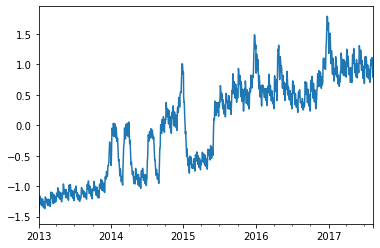

In [208]:
ses_fit.predict(idx[0]).plot()

## Hodrick-Prescott Filter

In [209]:
from statsmodels.tsa.filters.hp_filter import hpfilter

<AxesSubplot:>

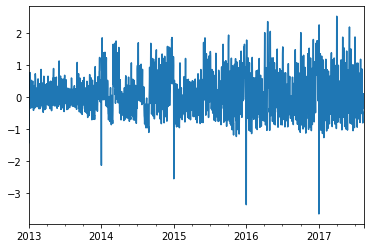

In [218]:
hpfilter(full_scld['sales'], lamb=3000000)[0].plot() #cycle

<AxesSubplot:>

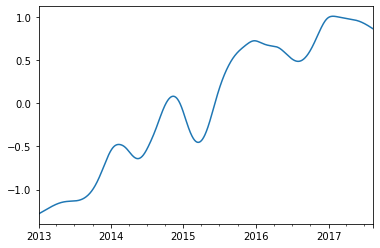

In [217]:
hpfilter(full_scld['sales'], lamb=3000000)[1].plot() #trend

## Fourier Transform

/Users/cephei/miniforge3/envs/general/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<AxesSubplot:>

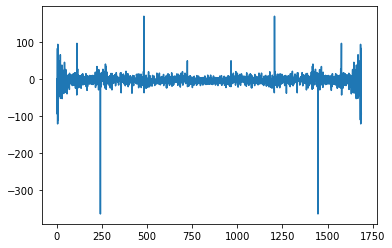

In [226]:
pd.Series(np.fft.fft(full_scld['sales'])).plot()

## Autoregression Integrated Moving Average (ARIMA)

In [433]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.stattools import adfuller

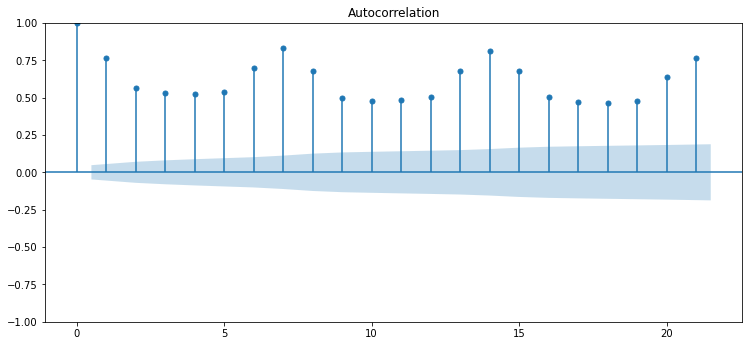

In [340]:
fig = plot_acf(full_scld['sales'], lags=21)
fig.set_size_inches(12.5, 5.5, forward=True)
plt.show()

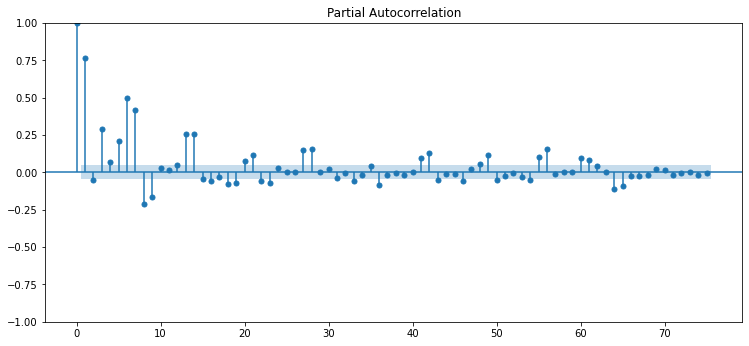

In [381]:
fig = plot_pacf(full_scld['sales'], lags=75)
fig.set_size_inches(12.5, 5.5, forward=True)
plt.show()

Clearly there is a weekly correlation here (at least).

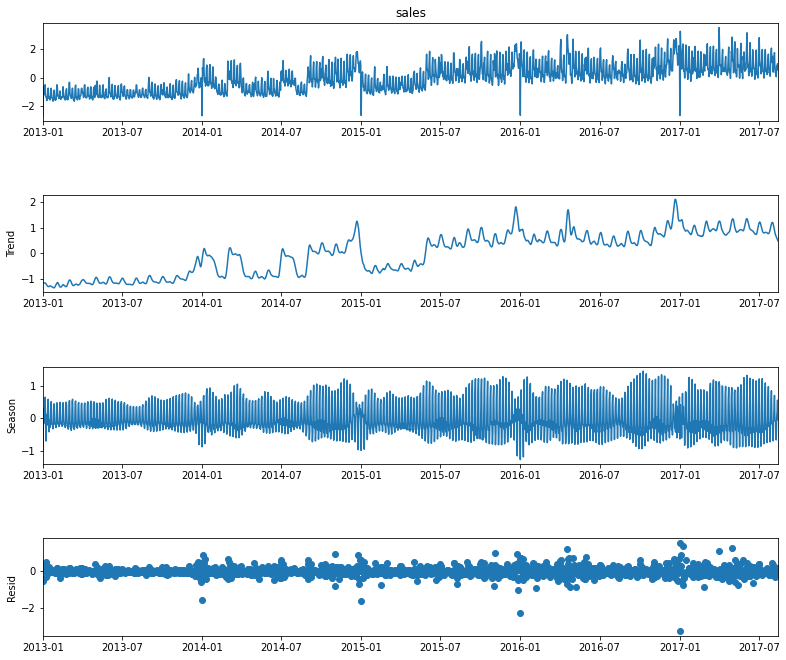

In [442]:
stl_split = STL(full_scld['sales'], period=7).fit()
fig = stl_split.plot()
fig.set_size_inches(12.5, 10.5, forward=True)
plt.show()

<AxesSubplot:>

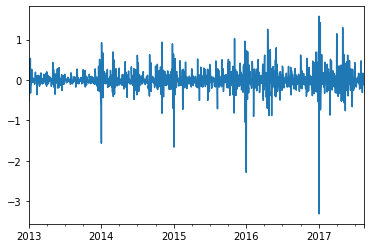

In [457]:
stl_split.resid.plot()

In [458]:
adfuller(stl_split.resid)[1] #This is the p-value for the test, and has to be <0.05 for it tobe stationary

1.9085874748554287e-27

In [605]:
arima_model = ARIMA(full_scld['sales'], order=(6,1,0), seasonal_order=(1,1,1,7)).fit()
sales_pred = arima_model.predict(idx[0])
sales_pred.loc[full_scld['sales'] < -2.5] = -2.7 #adjusting for NYD

In [606]:
avg_ny2_sales = (full_scld['sales'].loc['2013-01-02'] + full_scld['sales'].loc['2014-01-02'] + 
                 full_scld['sales'].loc['2015-01-02'] + full_scld['sales'].loc['2016-01-02'] + 
                 full_scld['sales'].loc['2017-01-02']) / 5

In [607]:
sales_pred.loc['2013-01-02'] = avg_ny2_sales #adjusting for shopping spree after NYD
sales_pred.loc['2014-01-02'] = avg_ny2_sales
sales_pred.loc['2015-01-02'] = avg_ny2_sales
sales_pred.loc['2016-01-02'] = avg_ny2_sales
sales_pred.loc['2017-01-02'] = avg_ny2_sales

In [608]:
error = full_scld['sales'] - sales_pred

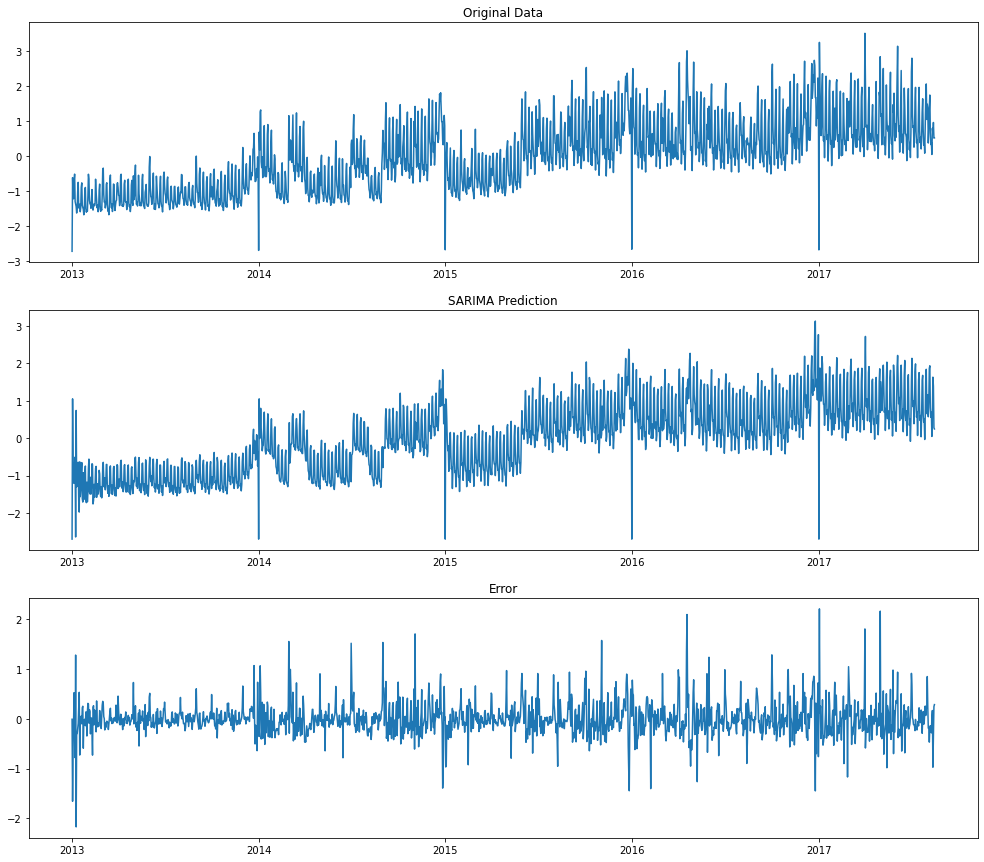

In [609]:
fig, ax = plt.subplots(3, 1, figsize=(17,15))
ax[0].plot(full_scld['sales'])
ax[0].set_title('Original Data')
ax[1].plot(sales_pred)
ax[1].set_title('SARIMA Prediction')
ax[2].plot(error)
ax[2].set_title('Error')
plt.show()

In [610]:
mean_sqrd_error = (error**2).mean()
print(mean_sqrd_error)

0.11417321971698766


# Time Series Analysis with CNNs